# Testing Environment for sample generations with GANs

### Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from Distribution_Shifting import Distribution_Shifting
from GAN_Models import DCGAN
from Normalization import Normalizer
from BatchSize_Optimization import batch_size_optimization
from Evaluation_metrics import p_Wasserstein_distance

### Loading Data for each tropical zone  - the datasets are the result of the Prepare_Data.py file ###

In [2]:
cur_dir = os.getcwd()
tropical_dataset = pd.read_csv(cur_dir + '\data\Tropical_dataset.csv')
subtropical_dataset = pd.read_csv(cur_dir + '\data\Subtropical_dataset.csv')
temperate_dataset = pd.read_csv(cur_dir + '\data\Temperate_dataset.csv')
polar_dataset = pd.read_csv(cur_dir + '\data\Polar_dataset.csv')

### Pipeline Class ###

In [3]:
class pipeline:
    def __init__(self, data, normalization_threshold, model, epochs, batch_size=128, Gloss_function=nn.L1Loss,
                 Dloss_function=nn.L1Loss):
        self.normalization_threshold = normalization_threshold
        self.batch_size = batch_size
        self.epochs = epochs
        self.best_batch_size = None
        self.Gloss_function = Gloss_function
        self.Dloss_function = Dloss_function
        normalizer = Normalizer(data, self.normalization_threshold)
        self.data, self.country_thresholds = normalizer.normalize()
        if model == 'DCGAN':
            self.model = model
        else:
            raise ValueError("Only DCGAN is supported at the moment")

    def batch_optimization(self, epochs=200, batch_size_list=[32, 64, 128, 256, 512], distance ='1-Wasserstein'):
        self.best_batch_size = batch_size_optimization(self.data, batch_size_list, epochs, self.model, distance)
        self.model = DCGAN(self.data, self.best_batch_size, self.epochs, self.Gloss_function, self.Dloss_function)
        
    def Distribution_Shifting(self, c, k):
        self.shifted_data = Distribution_Shifting(self.data, c, k, self.model)
        plt.hist(self.shifted_data, bins='auto',color= 'r')
        plt.title("Synthetic Data")
        plt.show()
        plt.hist(self.data, bins='auto',color = 'r')
        plt.title("Real Data")
        plt.show()
        return self.shifted_data

### Testing on Tropical Dataset ###

In [4]:
pipe = pipeline(tropical_dataset, 
               normalization_threshold = 0.3,
               model = 'DCGAN',
               epochs = 200,
               batch_size = 128,
               Gloss_function= nn.L1Loss,
               Dloss_function= nn.L1Loss)

Data were normalized using the exceedance based method with threshold:  0.3


In [5]:
pipe.batch_optimization(epochs = 10,
                       batch_size_list = [64,128,256],
                        distance = '1-Wasserstein')

Training the GAN with batch size:  64
Training the GAN with batch size:  128
Training the GAN with batch size:  256
The best batch size is 64 with a 1-Wasserstein distance of 37.2676


Distribution Shifting Started
Iteration:  1
The 1-Wasserstein distance between initial dataset and iteration 1 is:  46.751078830620905
Iteration:  2
The 1-Wasserstein distance between initial dataset and iteration 2 is:  96.11960418313485
Iteration:  3
The 1-Wasserstein distance between initial dataset and iteration 3 is:  303.57527318501


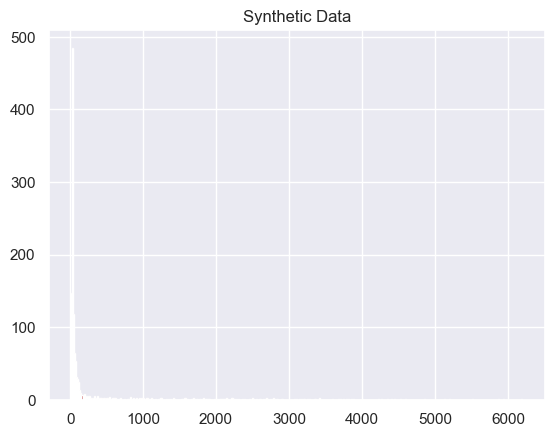

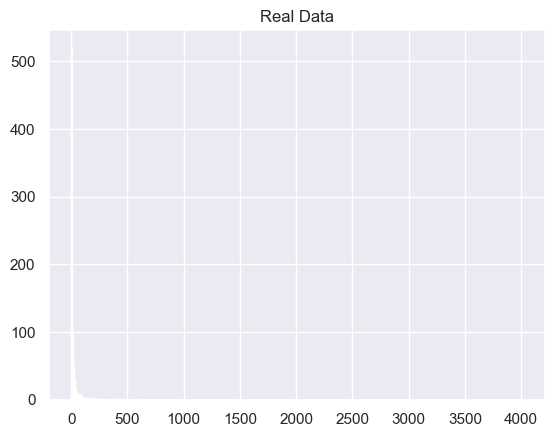

array([  15.07712809,   15.25293177,   15.31888291, ..., 5863.08300781,
       5931.546875  , 6194.8359375 ])

In [6]:
dist_shifting_parameter = 0.7
iterations = 3

pipe.Distribution_Shifting(c = dist_shifting_parameter,k = iterations)